**Imports**

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.utils import np_utils
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, LeakyReLU

### Plotting results

In [2]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    %tensorflow_version 1.x
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric))
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric))
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

**Load and Split data**

In [3]:
val_number=6000 #10% of the training dataset
classes = 10

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

val_images = train_images[:val_number]
val_labels = train_labels[:val_number]
train_images = train_images[val_number:]
train_labels = train_labels[val_number:]

print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

train_images = np.repeat(train_images[..., np.newaxis],3,-1)
test_images = np.repeat(test_images[..., np.newaxis],3,-1)
val_images = np.repeat(val_images[..., np.newaxis],3,-1)

print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

4423680/4422102 [==============================] - 0s 0us/step
(54000, 28, 28)
(6000, 28, 28)
(10000, 28, 28)
(54000, 28, 28, 3)
(6000, 28, 28, 3)
(10000, 28, 28, 3)


**Data Processing for VGG19**

In [4]:
train_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_images])
test_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_images])
val_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in val_images])

val_images= val_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0
val_images = val_images /255.0

val_labels = np_utils.to_categorical(val_labels, classes)
test_labels = np_utils.to_categorical(test_labels, classes)
train_labels = np_utils.to_categorical(train_labels, classes)

train_images = preprocess_input(train_images)
test_images = preprocess_input(test_images)
val_images = preprocess_input(val_images)

train_images.shape, test_images.shape, val_images.shape

((54000, 48, 48, 3), (10000, 48, 48, 3), (6000, 48, 48, 3))

**VGG19**

In [5]:
base_model = VGG19(input_shape=(48,48,3), include_top=False, weights='imagenet')
base_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

**Extracting Features**

In [6]:
train_features = base_model.predict(np.array(train_images), batch_size=512, verbose=1)
test_features = base_model.predict(np.array(test_images), batch_size=512, verbose=1)
val_features = base_model.predict(np.array(val_images), batch_size=512, verbose=1)

12/12 [==============================] - 2s 221ms/step


**Saving the features for later use**

In [7]:
np.savez("train_features", train_features, train_labels)
np.savez("test_features", test_features, test_labels)
np.savez("val_features", val_features, val_labels)

**Loading features**

In [8]:
npzfile_test = np.load("test_features.npz")
npzfile_train = np.load("train_features.npz")
npzfile_val = np.load("val_features.npz")
print(npzfile_val.files)
reloaded_test_features=npzfile_test['arr_0']
reloaded_test_labels=npzfile_test['arr_1']
reloaded_train_features=npzfile_train['arr_0']
reloaded_train_labels=npzfile_train['arr_1']
reloaded_val_features=npzfile_val['arr_0']
reloaded_val_labels=npzfile_val['arr_1']
reloaded_test_features.shape
np.array_equal(reloaded_test_features,test_features),np.array_equal(reloaded_train_features,train_features),np.array_equal(reloaded_val_features,val_features)

['arr_0', 'arr_1']


(True, True, True)

In [9]:
print(train_features.shape)
train_features_flat = np.reshape(reloaded_train_features, (54000, 1*1*512))
test_features_flat = np.reshape(reloaded_test_features, (10000, 1*1*512))
val_features_flat = np.reshape(reloaded_val_features, (6000, 1*1*512))

(54000, 1, 1, 512)


In [10]:
'''model = keras.Sequential()
model.add(keras.layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))'''

model = keras.Sequential()
model.add(keras.layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(keras.layers.LeakyReLU(alpha=0.1))
model.add(keras.layers.Dense(10,activation='softmax'))

**Compile and Train the model**

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features_flat, train_labels, epochs=20,validation_data=(val_features_flat, val_labels))

Epoch 1/20
1688/1688 [==============================] - 5s 2ms/step - loss: 2.0371 - accuracy: 0.3201 - val_loss: 1.2157 - val_accuracy: 0.5927
Epoch 2/20
1688/1688 [==============================] - 4s 2ms/step - loss: 1.2629 - accuracy: 0.5383 - val_loss: 1.0643 - val_accuracy: 0.6268
Epoch 3/20
1688/1688 [==============================] - 4s 2ms/step - loss: 1.1187 - accuracy: 0.5962 - val_loss: 1.0312 - val_accuracy: 0.6180
Epoch 4/20
1688/1688 [==============================] - 4s 2ms/step - loss: 1.0336 - accuracy: 0.6259 - val_loss: 0.9383 - val_accuracy: 0.6507
Epoch 5/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.9927 - accuracy: 0.6377 - val_loss: 1.0588 - val_accuracy: 0.6005
Epoch 6/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.9644 - accuracy: 0.6497 - val_loss: 0.8737 - val_accuracy: 0.6790
Epoch 7/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.9359 - accuracy: 0.6593 - val_loss: 0.8699 - val_accuracy:

**Save the model**(not needed here)

In [15]:
evaluation = model.evaluate(test_features_flat,  test_labels, verbose=2)

313/313 - 0s - loss: 0.7915 - accuracy: 0.7080


Train Loss     : 0.82234
Validation Loss: 0.75073
Test Loss      : 0.79149
---
Train Accuracy     : 0.70020
Validation Accuracy: 0.73217
Test Accuracy      : 0.70800

TensorFlow is already loaded. Please restart the runtime to change versions.


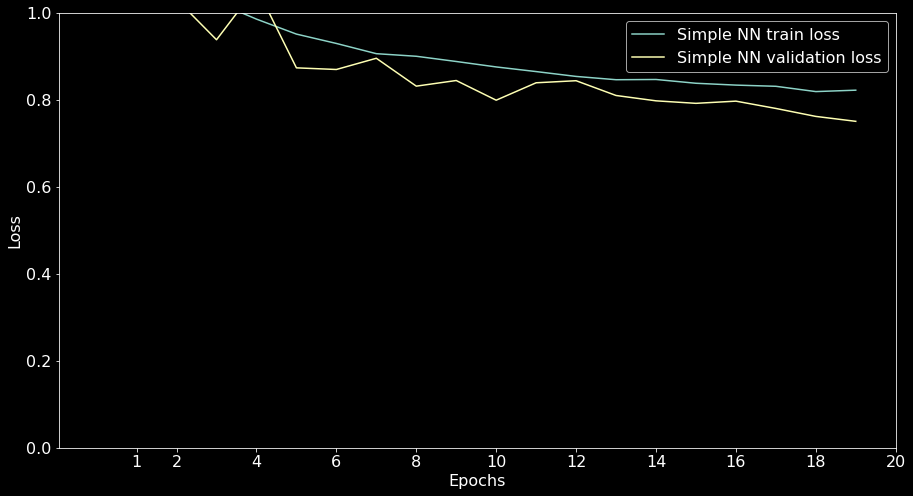


TensorFlow is already loaded. Please restart the runtime to change versions.


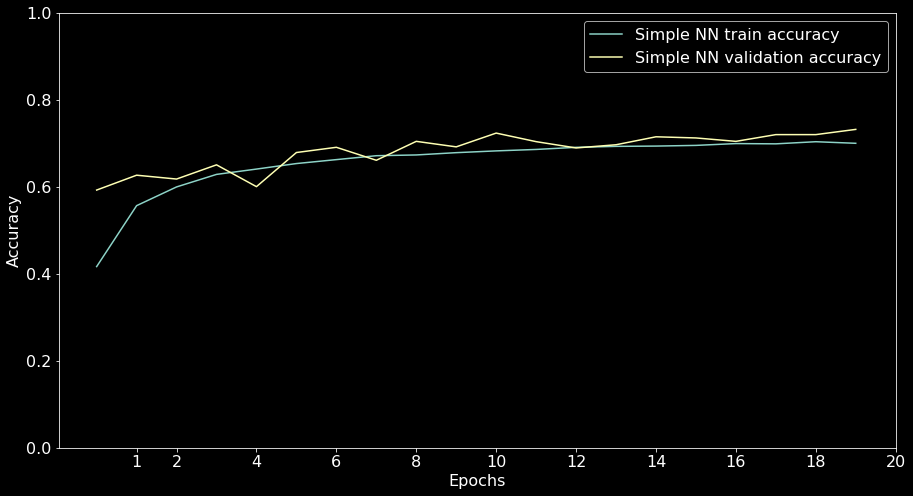

In [17]:
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(evaluation[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(evaluation[1]))

plot_history(hs={'Simple NN': history}, epochs=20, metric='loss')
plot_history(hs={'Simple NN': history}, epochs=20, metric='accuracy')